In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False)

cuda
Files already downloaded and verified
Files already downloaded and verified


In [11]:
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(4096, 10)
vgg16.to(device)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
# optimizer
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

In [13]:
#transformations for metamorphic testing
transformations = [
    transforms.RandomRotation(degrees=10),  # Small rotation
    transforms.ColorJitter(brightness=0.2),  # Slight brightness change
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))  # Small translation
]

In [14]:
# Validation Function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in tqdm(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_running_loss += loss.item()
            _, preds = torch.max(output.data, 1)
            val_running_correct += (preds == target).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    val_loss = val_running_loss / len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct / len(test_dataloader.dataset)
    
    # Calculate metrics
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    
    return val_loss, val_accuracy, precision, recall, f1

In [15]:
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for  data, target in tqdm(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

In [22]:
reject_diffs = []

# If batch_size > 1, we get multiple images each iteration.
for i, (image, label) in enumerate(tqdm(testloader)):
   
    image = image.to(device)


    with torch.no_grad():
        original_output = vgg16(image)
        original_prob = F.softmax(original_output, dim=1)
        original_confidence, original_pred = torch.max(original_prob, dim=1)  # shape [batch_size]

    
    for tf in transformations:
        transformed_image = tf(image.cpu()).to(device)
        
        with torch.no_grad():
            transformed_output = vgg16(transformed_image)
            transformed_prob = F.softmax(transformed_output, dim=1)
            transformed_confidence, transformed_pred = torch.max(transformed_prob, dim=1)
        
        # Compute absolute difference in confidence for the entire batch
        # shape [batch_size]
        diff_tensor = torch.abs(original_confidence - transformed_confidence)

        
        diff_mean = diff_tensor.mean().item()
        reject_diffs.append(diff_mean)

        
        print(f"Batch {i} | "
              f"Reject Differential (mean over batch): {diff_mean:.4f}")

  0%|                                                                                        | 0/313 [00:00<?, ?it/s]

Batch 0 | Reject Differential (mean over batch): 0.0340
Batch 0 | Reject Differential (mean over batch): 0.0308


  0%|▎                                                                               | 1/313 [00:00<02:34,  2.02it/s]

Batch 0 | Reject Differential (mean over batch): 0.0376
Batch 1 | Reject Differential (mean over batch): 0.0272
Batch 1 | Reject Differential (mean over batch): 0.0292


  1%|▌                                                                               | 2/313 [00:00<02:28,  2.09it/s]

Batch 1 | Reject Differential (mean over batch): 0.0320


  1%|▊                                                                               | 3/313 [00:01<02:23,  2.16it/s]

Batch 2 | Reject Differential (mean over batch): 0.0299
Batch 2 | Reject Differential (mean over batch): 0.0304
Batch 2 | Reject Differential (mean over batch): 0.0321
Batch 3 | Reject Differential (mean over batch): 0.0344
Batch 3 | Reject Differential (mean over batch): 0.0324


  1%|█                                                                               | 4/313 [00:01<02:22,  2.18it/s]

Batch 3 | Reject Differential (mean over batch): 0.0362


  2%|█▎                                                                              | 5/313 [00:02<02:18,  2.22it/s]

Batch 4 | Reject Differential (mean over batch): 0.0320
Batch 4 | Reject Differential (mean over batch): 0.0380
Batch 4 | Reject Differential (mean over batch): 0.0346


  2%|█▌                                                                              | 6/313 [00:02<02:17,  2.23it/s]

Batch 5 | Reject Differential (mean over batch): 0.0309
Batch 5 | Reject Differential (mean over batch): 0.0293
Batch 5 | Reject Differential (mean over batch): 0.0292
Batch 6 | Reject Differential (mean over batch): 0.0300
Batch 6 | Reject Differential (mean over batch): 0.0330


  2%|█▊                                                                              | 7/313 [00:03<02:18,  2.21it/s]

Batch 6 | Reject Differential (mean over batch): 0.0394


  3%|██                                                                              | 8/313 [00:03<02:15,  2.25it/s]

Batch 7 | Reject Differential (mean over batch): 0.0320
Batch 7 | Reject Differential (mean over batch): 0.0358
Batch 7 | Reject Differential (mean over batch): 0.0323
Batch 8 | Reject Differential (mean over batch): 0.0373
Batch 8 | Reject Differential (mean over batch): 0.0383


  3%|██▎                                                                             | 9/313 [00:04<02:15,  2.24it/s]

Batch 8 | Reject Differential (mean over batch): 0.0307
Batch 9 | Reject Differential (mean over batch): 0.0313
Batch 9 | Reject Differential (mean over batch): 0.0337


  3%|██▌                                                                            | 10/313 [00:04<02:14,  2.26it/s]

Batch 9 | Reject Differential (mean over batch): 0.0315


  4%|██▊                                                                            | 11/313 [00:04<02:12,  2.27it/s]

Batch 10 | Reject Differential (mean over batch): 0.0297
Batch 10 | Reject Differential (mean over batch): 0.0355
Batch 10 | Reject Differential (mean over batch): 0.0325


  4%|███                                                                            | 12/313 [00:05<02:10,  2.30it/s]

Batch 11 | Reject Differential (mean over batch): 0.0291
Batch 11 | Reject Differential (mean over batch): 0.0357
Batch 11 | Reject Differential (mean over batch): 0.0307


  4%|███▎                                                                           | 13/313 [00:05<02:08,  2.33it/s]

Batch 12 | Reject Differential (mean over batch): 0.0249
Batch 12 | Reject Differential (mean over batch): 0.0311
Batch 12 | Reject Differential (mean over batch): 0.0365


  4%|███▌                                                                           | 14/313 [00:06<02:07,  2.35it/s]

Batch 13 | Reject Differential (mean over batch): 0.0251
Batch 13 | Reject Differential (mean over batch): 0.0368
Batch 13 | Reject Differential (mean over batch): 0.0319


  5%|███▊                                                                           | 15/313 [00:06<02:06,  2.36it/s]

Batch 14 | Reject Differential (mean over batch): 0.0263
Batch 14 | Reject Differential (mean over batch): 0.0381
Batch 14 | Reject Differential (mean over batch): 0.0309


  5%|████                                                                           | 16/313 [00:07<02:07,  2.32it/s]

Batch 15 | Reject Differential (mean over batch): 0.0246
Batch 15 | Reject Differential (mean over batch): 0.0277
Batch 15 | Reject Differential (mean over batch): 0.0307


  5%|████▎                                                                          | 17/313 [00:07<02:07,  2.32it/s]

Batch 16 | Reject Differential (mean over batch): 0.0338
Batch 16 | Reject Differential (mean over batch): 0.0317
Batch 16 | Reject Differential (mean over batch): 0.0409


  6%|████▌                                                                          | 18/313 [00:07<02:07,  2.32it/s]

Batch 17 | Reject Differential (mean over batch): 0.0367
Batch 17 | Reject Differential (mean over batch): 0.0359
Batch 17 | Reject Differential (mean over batch): 0.0395
Batch 18 | Reject Differential (mean over batch): 0.0410
Batch 18 | Reject Differential (mean over batch): 0.0404


  6%|████▊                                                                          | 19/313 [00:08<02:07,  2.31it/s]

Batch 18 | Reject Differential (mean over batch): 0.0446


  6%|█████                                                                          | 20/313 [00:08<02:05,  2.33it/s]

Batch 19 | Reject Differential (mean over batch): 0.0264
Batch 19 | Reject Differential (mean over batch): 0.0282
Batch 19 | Reject Differential (mean over batch): 0.0258


  7%|█████▎                                                                         | 21/313 [00:09<02:05,  2.32it/s]

Batch 20 | Reject Differential (mean over batch): 0.0344
Batch 20 | Reject Differential (mean over batch): 0.0393
Batch 20 | Reject Differential (mean over batch): 0.0305
Batch 21 | Reject Differential (mean over batch): 0.0222
Batch 21 | Reject Differential (mean over batch): 0.0298


  7%|█████▌                                                                         | 22/313 [00:09<02:06,  2.31it/s]

Batch 21 | Reject Differential (mean over batch): 0.0259


  7%|█████▊                                                                         | 23/313 [00:10<02:05,  2.30it/s]

Batch 22 | Reject Differential (mean over batch): 0.0341
Batch 22 | Reject Differential (mean over batch): 0.0367
Batch 22 | Reject Differential (mean over batch): 0.0352


  8%|██████                                                                         | 24/313 [00:10<02:04,  2.31it/s]

Batch 23 | Reject Differential (mean over batch): 0.0297
Batch 23 | Reject Differential (mean over batch): 0.0307
Batch 23 | Reject Differential (mean over batch): 0.0230


  8%|██████▎                                                                        | 25/313 [00:10<02:03,  2.33it/s]

Batch 24 | Reject Differential (mean over batch): 0.0334
Batch 24 | Reject Differential (mean over batch): 0.0352
Batch 24 | Reject Differential (mean over batch): 0.0387


  8%|██████▌                                                                        | 26/313 [00:11<02:03,  2.32it/s]

Batch 25 | Reject Differential (mean over batch): 0.0329
Batch 25 | Reject Differential (mean over batch): 0.0436
Batch 25 | Reject Differential (mean over batch): 0.0366
Batch 26 | Reject Differential (mean over batch): 0.0293
Batch 26 | Reject Differential (mean over batch): 0.0383


  9%|██████▊                                                                        | 27/313 [00:11<02:04,  2.29it/s]

Batch 26 | Reject Differential (mean over batch): 0.0324


  9%|███████                                                                        | 28/313 [00:12<02:04,  2.29it/s]

Batch 27 | Reject Differential (mean over batch): 0.0411
Batch 27 | Reject Differential (mean over batch): 0.0424
Batch 27 | Reject Differential (mean over batch): 0.0419


  9%|███████▎                                                                       | 29/313 [00:12<02:02,  2.31it/s]

Batch 28 | Reject Differential (mean over batch): 0.0330
Batch 28 | Reject Differential (mean over batch): 0.0302
Batch 28 | Reject Differential (mean over batch): 0.0336


 10%|███████▌                                                                       | 30/313 [00:13<02:02,  2.32it/s]

Batch 29 | Reject Differential (mean over batch): 0.0337
Batch 29 | Reject Differential (mean over batch): 0.0410
Batch 29 | Reject Differential (mean over batch): 0.0382
Batch 30 | Reject Differential (mean over batch): 0.0290
Batch 30 | Reject Differential (mean over batch): 0.0321


 10%|███████▊                                                                       | 31/313 [00:13<02:01,  2.31it/s]

Batch 30 | Reject Differential (mean over batch): 0.0316


 10%|████████                                                                       | 32/313 [00:13<02:02,  2.29it/s]

Batch 31 | Reject Differential (mean over batch): 0.0205
Batch 31 | Reject Differential (mean over batch): 0.0258
Batch 31 | Reject Differential (mean over batch): 0.0287


 11%|████████▎                                                                      | 33/313 [00:14<02:01,  2.31it/s]

Batch 32 | Reject Differential (mean over batch): 0.0329
Batch 32 | Reject Differential (mean over batch): 0.0269
Batch 32 | Reject Differential (mean over batch): 0.0320


 11%|████████▌                                                                      | 34/313 [00:14<01:59,  2.33it/s]

Batch 33 | Reject Differential (mean over batch): 0.0256
Batch 33 | Reject Differential (mean over batch): 0.0315
Batch 33 | Reject Differential (mean over batch): 0.0325


 11%|████████▊                                                                      | 35/313 [00:15<01:59,  2.33it/s]

Batch 34 | Reject Differential (mean over batch): 0.0351
Batch 34 | Reject Differential (mean over batch): 0.0316
Batch 34 | Reject Differential (mean over batch): 0.0380


 12%|█████████                                                                      | 36/313 [00:15<01:58,  2.34it/s]

Batch 35 | Reject Differential (mean over batch): 0.0318
Batch 35 | Reject Differential (mean over batch): 0.0314
Batch 35 | Reject Differential (mean over batch): 0.0313


 12%|█████████▎                                                                     | 37/313 [00:16<01:57,  2.34it/s]

Batch 36 | Reject Differential (mean over batch): 0.0330
Batch 36 | Reject Differential (mean over batch): 0.0348
Batch 36 | Reject Differential (mean over batch): 0.0367


 12%|█████████▌                                                                     | 38/313 [00:16<01:56,  2.36it/s]

Batch 37 | Reject Differential (mean over batch): 0.0256
Batch 37 | Reject Differential (mean over batch): 0.0316
Batch 37 | Reject Differential (mean over batch): 0.0354


 12%|█████████▊                                                                     | 39/313 [00:16<01:56,  2.36it/s]

Batch 38 | Reject Differential (mean over batch): 0.0244
Batch 38 | Reject Differential (mean over batch): 0.0322
Batch 38 | Reject Differential (mean over batch): 0.0307


 13%|██████████                                                                     | 40/313 [00:17<01:55,  2.35it/s]

Batch 39 | Reject Differential (mean over batch): 0.0350
Batch 39 | Reject Differential (mean over batch): 0.0335
Batch 39 | Reject Differential (mean over batch): 0.0393


 13%|██████████▎                                                                    | 41/313 [00:17<01:55,  2.36it/s]

Batch 40 | Reject Differential (mean over batch): 0.0271
Batch 40 | Reject Differential (mean over batch): 0.0308
Batch 40 | Reject Differential (mean over batch): 0.0309


 13%|██████████▌                                                                    | 42/313 [00:18<01:54,  2.37it/s]

Batch 41 | Reject Differential (mean over batch): 0.0240
Batch 41 | Reject Differential (mean over batch): 0.0272
Batch 41 | Reject Differential (mean over batch): 0.0283


 14%|██████████▊                                                                    | 43/313 [00:18<01:53,  2.38it/s]

Batch 42 | Reject Differential (mean over batch): 0.0311
Batch 42 | Reject Differential (mean over batch): 0.0350
Batch 42 | Reject Differential (mean over batch): 0.0347
Batch 43 | Reject Differential (mean over batch): 0.0280
Batch 43 | Reject Differential (mean over batch): 0.0270


 14%|███████████                                                                    | 44/313 [00:19<01:54,  2.35it/s]

Batch 43 | Reject Differential (mean over batch): 0.0191


 14%|███████████▎                                                                   | 45/313 [00:19<01:53,  2.35it/s]

Batch 44 | Reject Differential (mean over batch): 0.0343
Batch 44 | Reject Differential (mean over batch): 0.0289
Batch 44 | Reject Differential (mean over batch): 0.0353


 15%|███████████▌                                                                   | 46/313 [00:19<01:55,  2.32it/s]

Batch 45 | Reject Differential (mean over batch): 0.0394
Batch 45 | Reject Differential (mean over batch): 0.0456
Batch 45 | Reject Differential (mean over batch): 0.0442


 15%|███████████▊                                                                   | 47/313 [00:20<01:53,  2.34it/s]

Batch 46 | Reject Differential (mean over batch): 0.0308
Batch 46 | Reject Differential (mean over batch): 0.0273
Batch 46 | Reject Differential (mean over batch): 0.0336


 15%|████████████                                                                   | 48/313 [00:20<01:53,  2.34it/s]

Batch 47 | Reject Differential (mean over batch): 0.0313
Batch 47 | Reject Differential (mean over batch): 0.0257
Batch 47 | Reject Differential (mean over batch): 0.0367


 16%|████████████▎                                                                  | 49/313 [00:21<01:52,  2.35it/s]

Batch 48 | Reject Differential (mean over batch): 0.0261
Batch 48 | Reject Differential (mean over batch): 0.0251
Batch 48 | Reject Differential (mean over batch): 0.0312


 16%|████████████▌                                                                  | 50/313 [00:21<01:52,  2.35it/s]

Batch 49 | Reject Differential (mean over batch): 0.0314
Batch 49 | Reject Differential (mean over batch): 0.0363
Batch 49 | Reject Differential (mean over batch): 0.0350


 16%|████████████▊                                                                  | 51/313 [00:22<01:50,  2.37it/s]

Batch 50 | Reject Differential (mean over batch): 0.0331
Batch 50 | Reject Differential (mean over batch): 0.0302
Batch 50 | Reject Differential (mean over batch): 0.0322


 17%|█████████████                                                                  | 52/313 [00:22<01:50,  2.37it/s]

Batch 51 | Reject Differential (mean over batch): 0.0366
Batch 51 | Reject Differential (mean over batch): 0.0384
Batch 51 | Reject Differential (mean over batch): 0.0382


 17%|█████████████▍                                                                 | 53/313 [00:22<01:49,  2.37it/s]

Batch 52 | Reject Differential (mean over batch): 0.0326
Batch 52 | Reject Differential (mean over batch): 0.0303
Batch 52 | Reject Differential (mean over batch): 0.0297


 17%|█████████████▋                                                                 | 54/313 [00:23<01:48,  2.38it/s]

Batch 53 | Reject Differential (mean over batch): 0.0345
Batch 53 | Reject Differential (mean over batch): 0.0259
Batch 53 | Reject Differential (mean over batch): 0.0319


 18%|█████████████▉                                                                 | 55/313 [00:23<01:48,  2.39it/s]

Batch 54 | Reject Differential (mean over batch): 0.0313
Batch 54 | Reject Differential (mean over batch): 0.0353
Batch 54 | Reject Differential (mean over batch): 0.0358


 18%|██████████████▏                                                                | 56/313 [00:24<01:47,  2.39it/s]

Batch 55 | Reject Differential (mean over batch): 0.0351
Batch 55 | Reject Differential (mean over batch): 0.0397
Batch 55 | Reject Differential (mean over batch): 0.0396


 18%|██████████████▍                                                                | 57/313 [00:24<01:46,  2.39it/s]

Batch 56 | Reject Differential (mean over batch): 0.0238
Batch 56 | Reject Differential (mean over batch): 0.0228
Batch 56 | Reject Differential (mean over batch): 0.0291


 19%|██████████████▋                                                                | 58/313 [00:24<01:46,  2.39it/s]

Batch 57 | Reject Differential (mean over batch): 0.0289
Batch 57 | Reject Differential (mean over batch): 0.0240
Batch 57 | Reject Differential (mean over batch): 0.0281


 19%|██████████████▉                                                                | 59/313 [00:25<01:46,  2.39it/s]

Batch 58 | Reject Differential (mean over batch): 0.0310
Batch 58 | Reject Differential (mean over batch): 0.0314
Batch 58 | Reject Differential (mean over batch): 0.0299


 19%|███████████████▏                                                               | 60/313 [00:25<01:45,  2.39it/s]

Batch 59 | Reject Differential (mean over batch): 0.0369
Batch 59 | Reject Differential (mean over batch): 0.0323
Batch 59 | Reject Differential (mean over batch): 0.0337


 19%|███████████████▍                                                               | 61/313 [00:26<01:45,  2.39it/s]

Batch 60 | Reject Differential (mean over batch): 0.0362
Batch 60 | Reject Differential (mean over batch): 0.0321
Batch 60 | Reject Differential (mean over batch): 0.0271


 20%|███████████████▋                                                               | 62/313 [00:26<01:44,  2.39it/s]

Batch 61 | Reject Differential (mean over batch): 0.0319
Batch 61 | Reject Differential (mean over batch): 0.0328
Batch 61 | Reject Differential (mean over batch): 0.0250


 20%|███████████████▉                                                               | 63/313 [00:27<01:45,  2.38it/s]

Batch 62 | Reject Differential (mean over batch): 0.0299
Batch 62 | Reject Differential (mean over batch): 0.0361
Batch 62 | Reject Differential (mean over batch): 0.0323


 20%|████████████████▏                                                              | 64/313 [00:27<01:44,  2.39it/s]

Batch 63 | Reject Differential (mean over batch): 0.0363
Batch 63 | Reject Differential (mean over batch): 0.0321
Batch 63 | Reject Differential (mean over batch): 0.0329


 21%|████████████████▍                                                              | 65/313 [00:27<01:43,  2.39it/s]

Batch 64 | Reject Differential (mean over batch): 0.0267
Batch 64 | Reject Differential (mean over batch): 0.0357
Batch 64 | Reject Differential (mean over batch): 0.0303


 21%|████████████████▋                                                              | 66/313 [00:28<01:43,  2.39it/s]

Batch 65 | Reject Differential (mean over batch): 0.0300
Batch 65 | Reject Differential (mean over batch): 0.0375
Batch 65 | Reject Differential (mean over batch): 0.0295


 21%|████████████████▉                                                              | 67/313 [00:28<01:42,  2.39it/s]

Batch 66 | Reject Differential (mean over batch): 0.0289
Batch 66 | Reject Differential (mean over batch): 0.0299
Batch 66 | Reject Differential (mean over batch): 0.0318


 22%|█████████████████▏                                                             | 68/313 [00:29<01:42,  2.39it/s]

Batch 67 | Reject Differential (mean over batch): 0.0407
Batch 67 | Reject Differential (mean over batch): 0.0389
Batch 67 | Reject Differential (mean over batch): 0.0356


 22%|█████████████████▍                                                             | 69/313 [00:29<01:42,  2.39it/s]

Batch 68 | Reject Differential (mean over batch): 0.0322
Batch 68 | Reject Differential (mean over batch): 0.0404
Batch 68 | Reject Differential (mean over batch): 0.0408


 22%|█████████████████▋                                                             | 70/313 [00:30<01:42,  2.38it/s]

Batch 69 | Reject Differential (mean over batch): 0.0271
Batch 69 | Reject Differential (mean over batch): 0.0298
Batch 69 | Reject Differential (mean over batch): 0.0232


 23%|█████████████████▉                                                             | 71/313 [00:30<01:41,  2.38it/s]

Batch 70 | Reject Differential (mean over batch): 0.0247
Batch 70 | Reject Differential (mean over batch): 0.0293
Batch 70 | Reject Differential (mean over batch): 0.0311


 23%|██████████████████▏                                                            | 72/313 [00:30<01:41,  2.37it/s]

Batch 71 | Reject Differential (mean over batch): 0.0313
Batch 71 | Reject Differential (mean over batch): 0.0341
Batch 71 | Reject Differential (mean over batch): 0.0293


 23%|██████████████████▍                                                            | 73/313 [00:31<01:41,  2.37it/s]

Batch 72 | Reject Differential (mean over batch): 0.0281
Batch 72 | Reject Differential (mean over batch): 0.0281
Batch 72 | Reject Differential (mean over batch): 0.0261


 24%|██████████████████▋                                                            | 74/313 [00:31<01:40,  2.37it/s]

Batch 73 | Reject Differential (mean over batch): 0.0258
Batch 73 | Reject Differential (mean over batch): 0.0233
Batch 73 | Reject Differential (mean over batch): 0.0244


 24%|██████████████████▉                                                            | 75/313 [00:32<01:39,  2.38it/s]

Batch 74 | Reject Differential (mean over batch): 0.0340
Batch 74 | Reject Differential (mean over batch): 0.0296
Batch 74 | Reject Differential (mean over batch): 0.0308


 24%|███████████████████▏                                                           | 76/313 [00:32<01:39,  2.39it/s]

Batch 75 | Reject Differential (mean over batch): 0.0300
Batch 75 | Reject Differential (mean over batch): 0.0285
Batch 75 | Reject Differential (mean over batch): 0.0265


 25%|███████████████████▍                                                           | 77/313 [00:32<01:38,  2.40it/s]

Batch 76 | Reject Differential (mean over batch): 0.0234
Batch 76 | Reject Differential (mean over batch): 0.0249
Batch 76 | Reject Differential (mean over batch): 0.0317


 25%|███████████████████▋                                                           | 78/313 [00:33<01:38,  2.40it/s]

Batch 77 | Reject Differential (mean over batch): 0.0292
Batch 77 | Reject Differential (mean over batch): 0.0321
Batch 77 | Reject Differential (mean over batch): 0.0342


 25%|███████████████████▉                                                           | 79/313 [00:33<01:37,  2.39it/s]

Batch 78 | Reject Differential (mean over batch): 0.0315
Batch 78 | Reject Differential (mean over batch): 0.0290
Batch 78 | Reject Differential (mean over batch): 0.0294


 26%|████████████████████▏                                                          | 80/313 [00:34<01:37,  2.40it/s]

Batch 79 | Reject Differential (mean over batch): 0.0317
Batch 79 | Reject Differential (mean over batch): 0.0331
Batch 79 | Reject Differential (mean over batch): 0.0329


 26%|████████████████████▍                                                          | 81/313 [00:34<01:37,  2.38it/s]

Batch 80 | Reject Differential (mean over batch): 0.0297
Batch 80 | Reject Differential (mean over batch): 0.0279
Batch 80 | Reject Differential (mean over batch): 0.0334


 26%|████████████████████▋                                                          | 82/313 [00:35<01:36,  2.38it/s]

Batch 81 | Reject Differential (mean over batch): 0.0356
Batch 81 | Reject Differential (mean over batch): 0.0359
Batch 81 | Reject Differential (mean over batch): 0.0338
Batch 82 | Reject Differential (mean over batch): 0.0268
Batch 82 | Reject Differential (mean over batch): 0.0290


 27%|████████████████████▉                                                          | 83/313 [00:35<01:37,  2.36it/s]

Batch 82 | Reject Differential (mean over batch): 0.0373


 27%|█████████████████████▏                                                         | 84/313 [00:35<01:37,  2.36it/s]

Batch 83 | Reject Differential (mean over batch): 0.0352
Batch 83 | Reject Differential (mean over batch): 0.0369
Batch 83 | Reject Differential (mean over batch): 0.0293


 27%|█████████████████████▍                                                         | 85/313 [00:36<01:36,  2.36it/s]

Batch 84 | Reject Differential (mean over batch): 0.0275
Batch 84 | Reject Differential (mean over batch): 0.0334
Batch 84 | Reject Differential (mean over batch): 0.0317


 27%|█████████████████████▋                                                         | 86/313 [00:36<01:37,  2.32it/s]

Batch 85 | Reject Differential (mean over batch): 0.0381
Batch 85 | Reject Differential (mean over batch): 0.0306
Batch 85 | Reject Differential (mean over batch): 0.0303


 28%|█████████████████████▉                                                         | 87/313 [00:37<01:36,  2.34it/s]

Batch 86 | Reject Differential (mean over batch): 0.0382
Batch 86 | Reject Differential (mean over batch): 0.0371
Batch 86 | Reject Differential (mean over batch): 0.0325


 28%|██████████████████████▏                                                        | 88/313 [00:37<01:36,  2.34it/s]

Batch 87 | Reject Differential (mean over batch): 0.0353
Batch 87 | Reject Differential (mean over batch): 0.0243
Batch 87 | Reject Differential (mean over batch): 0.0231


 28%|██████████████████████▍                                                        | 89/313 [00:38<01:35,  2.34it/s]

Batch 88 | Reject Differential (mean over batch): 0.0256
Batch 88 | Reject Differential (mean over batch): 0.0276
Batch 88 | Reject Differential (mean over batch): 0.0298


 29%|██████████████████████▋                                                        | 90/313 [00:38<01:34,  2.35it/s]

Batch 89 | Reject Differential (mean over batch): 0.0365
Batch 89 | Reject Differential (mean over batch): 0.0396
Batch 89 | Reject Differential (mean over batch): 0.0287


 29%|██████████████████████▉                                                        | 91/313 [00:38<01:34,  2.36it/s]

Batch 90 | Reject Differential (mean over batch): 0.0244
Batch 90 | Reject Differential (mean over batch): 0.0263
Batch 90 | Reject Differential (mean over batch): 0.0302


 29%|███████████████████████▏                                                       | 92/313 [00:39<01:33,  2.37it/s]

Batch 91 | Reject Differential (mean over batch): 0.0377
Batch 91 | Reject Differential (mean over batch): 0.0410
Batch 91 | Reject Differential (mean over batch): 0.0360


 30%|███████████████████████▍                                                       | 93/313 [00:39<01:32,  2.38it/s]

Batch 92 | Reject Differential (mean over batch): 0.0282
Batch 92 | Reject Differential (mean over batch): 0.0342
Batch 92 | Reject Differential (mean over batch): 0.0377


 30%|███████████████████████▋                                                       | 94/313 [00:40<01:31,  2.39it/s]

Batch 93 | Reject Differential (mean over batch): 0.0275
Batch 93 | Reject Differential (mean over batch): 0.0350
Batch 93 | Reject Differential (mean over batch): 0.0272


 30%|███████████████████████▉                                                       | 95/313 [00:40<01:32,  2.37it/s]

Batch 94 | Reject Differential (mean over batch): 0.0293
Batch 94 | Reject Differential (mean over batch): 0.0336
Batch 94 | Reject Differential (mean over batch): 0.0278


 31%|████████████████████████▏                                                      | 96/313 [00:40<01:31,  2.38it/s]

Batch 95 | Reject Differential (mean over batch): 0.0427
Batch 95 | Reject Differential (mean over batch): 0.0405
Batch 95 | Reject Differential (mean over batch): 0.0347
Batch 96 | Reject Differential (mean over batch): 0.0270
Batch 96 | Reject Differential (mean over batch): 0.0278


 31%|████████████████████████▍                                                      | 97/313 [00:41<01:32,  2.34it/s]

Batch 96 | Reject Differential (mean over batch): 0.0289


 31%|████████████████████████▋                                                      | 98/313 [00:41<01:31,  2.36it/s]

Batch 97 | Reject Differential (mean over batch): 0.0342
Batch 97 | Reject Differential (mean over batch): 0.0321
Batch 97 | Reject Differential (mean over batch): 0.0262


 32%|████████████████████████▉                                                      | 99/313 [00:42<01:30,  2.37it/s]

Batch 98 | Reject Differential (mean over batch): 0.0370
Batch 98 | Reject Differential (mean over batch): 0.0361
Batch 98 | Reject Differential (mean over batch): 0.0398


 32%|████████████████████████▉                                                     | 100/313 [00:42<01:30,  2.36it/s]

Batch 99 | Reject Differential (mean over batch): 0.0368
Batch 99 | Reject Differential (mean over batch): 0.0366
Batch 99 | Reject Differential (mean over batch): 0.0305


 32%|█████████████████████████▏                                                    | 101/313 [00:43<01:30,  2.35it/s]

Batch 100 | Reject Differential (mean over batch): 0.0355
Batch 100 | Reject Differential (mean over batch): 0.0386
Batch 100 | Reject Differential (mean over batch): 0.0329


 33%|█████████████████████████▍                                                    | 102/313 [00:43<01:29,  2.37it/s]

Batch 101 | Reject Differential (mean over batch): 0.0276
Batch 101 | Reject Differential (mean over batch): 0.0283
Batch 101 | Reject Differential (mean over batch): 0.0338


 33%|█████████████████████████▋                                                    | 103/313 [00:43<01:28,  2.37it/s]

Batch 102 | Reject Differential (mean over batch): 0.0483
Batch 102 | Reject Differential (mean over batch): 0.0506
Batch 102 | Reject Differential (mean over batch): 0.0440


 33%|█████████████████████████▉                                                    | 104/313 [00:44<01:27,  2.38it/s]

Batch 103 | Reject Differential (mean over batch): 0.0379
Batch 103 | Reject Differential (mean over batch): 0.0236
Batch 103 | Reject Differential (mean over batch): 0.0337
Batch 104 | Reject Differential (mean over batch): 0.0287
Batch 104 | Reject Differential (mean over batch): 0.0307


 34%|██████████████████████████▏                                                   | 105/313 [00:44<01:28,  2.35it/s]

Batch 104 | Reject Differential (mean over batch): 0.0324


 34%|██████████████████████████▍                                                   | 106/313 [00:45<01:27,  2.36it/s]

Batch 105 | Reject Differential (mean over batch): 0.0386
Batch 105 | Reject Differential (mean over batch): 0.0392
Batch 105 | Reject Differential (mean over batch): 0.0370


 34%|██████████████████████████▋                                                   | 107/313 [00:45<01:27,  2.35it/s]

Batch 106 | Reject Differential (mean over batch): 0.0420
Batch 106 | Reject Differential (mean over batch): 0.0338
Batch 106 | Reject Differential (mean over batch): 0.0318
Batch 107 | Reject Differential (mean over batch): 0.0316
Batch 107 | Reject Differential (mean over batch): 0.0297


 35%|██████████████████████████▉                                                   | 108/313 [00:46<01:27,  2.35it/s]

Batch 107 | Reject Differential (mean over batch): 0.0280
Batch 108 | Reject Differential (mean over batch): 0.0348
Batch 108 | Reject Differential (mean over batch): 0.0378


 35%|███████████████████████████▏                                                  | 109/313 [00:46<01:28,  2.29it/s]

Batch 108 | Reject Differential (mean over batch): 0.0365
Batch 109 | Reject Differential (mean over batch): 0.0315
Batch 109 | Reject Differential (mean over batch): 0.0285


 35%|███████████████████████████▍                                                  | 110/313 [00:46<01:28,  2.29it/s]

Batch 109 | Reject Differential (mean over batch): 0.0340


 35%|███████████████████████████▋                                                  | 111/313 [00:47<01:27,  2.30it/s]

Batch 110 | Reject Differential (mean over batch): 0.0272
Batch 110 | Reject Differential (mean over batch): 0.0304
Batch 110 | Reject Differential (mean over batch): 0.0351
Batch 111 | Reject Differential (mean over batch): 0.0341
Batch 111 | Reject Differential (mean over batch): 0.0327


 36%|███████████████████████████▉                                                  | 112/313 [00:47<01:27,  2.29it/s]

Batch 111 | Reject Differential (mean over batch): 0.0331


 36%|████████████████████████████▏                                                 | 113/313 [00:48<01:26,  2.31it/s]

Batch 112 | Reject Differential (mean over batch): 0.0345
Batch 112 | Reject Differential (mean over batch): 0.0358
Batch 112 | Reject Differential (mean over batch): 0.0268


 36%|████████████████████████████▍                                                 | 114/313 [00:48<01:25,  2.32it/s]

Batch 113 | Reject Differential (mean over batch): 0.0343
Batch 113 | Reject Differential (mean over batch): 0.0357
Batch 113 | Reject Differential (mean over batch): 0.0247


 37%|████████████████████████████▋                                                 | 115/313 [00:49<01:24,  2.33it/s]

Batch 114 | Reject Differential (mean over batch): 0.0387
Batch 114 | Reject Differential (mean over batch): 0.0428
Batch 114 | Reject Differential (mean over batch): 0.0410


 37%|████████████████████████████▉                                                 | 116/313 [00:49<01:23,  2.35it/s]

Batch 115 | Reject Differential (mean over batch): 0.0289
Batch 115 | Reject Differential (mean over batch): 0.0224
Batch 115 | Reject Differential (mean over batch): 0.0249


 37%|█████████████████████████████▏                                                | 117/313 [00:49<01:23,  2.36it/s]

Batch 116 | Reject Differential (mean over batch): 0.0334
Batch 116 | Reject Differential (mean over batch): 0.0344
Batch 116 | Reject Differential (mean over batch): 0.0369


 38%|█████████████████████████████▍                                                | 118/313 [00:50<01:23,  2.35it/s]

Batch 117 | Reject Differential (mean over batch): 0.0321
Batch 117 | Reject Differential (mean over batch): 0.0308
Batch 117 | Reject Differential (mean over batch): 0.0257


 38%|█████████████████████████████▋                                                | 119/313 [00:50<01:22,  2.35it/s]

Batch 118 | Reject Differential (mean over batch): 0.0285
Batch 118 | Reject Differential (mean over batch): 0.0261
Batch 118 | Reject Differential (mean over batch): 0.0193


 38%|█████████████████████████████▉                                                | 120/313 [00:51<01:22,  2.34it/s]

Batch 119 | Reject Differential (mean over batch): 0.0255
Batch 119 | Reject Differential (mean over batch): 0.0302
Batch 119 | Reject Differential (mean over batch): 0.0278
Batch 120 | Reject Differential (mean over batch): 0.0294
Batch 120 | Reject Differential (mean over batch): 0.0293


 39%|██████████████████████████████▏                                               | 121/313 [00:51<01:24,  2.28it/s]

Batch 120 | Reject Differential (mean over batch): 0.0312


 39%|██████████████████████████████▍                                               | 122/313 [00:52<01:22,  2.31it/s]

Batch 121 | Reject Differential (mean over batch): 0.0297
Batch 121 | Reject Differential (mean over batch): 0.0284
Batch 121 | Reject Differential (mean over batch): 0.0284


 39%|██████████████████████████████▋                                               | 123/313 [00:52<01:21,  2.33it/s]

Batch 122 | Reject Differential (mean over batch): 0.0285
Batch 122 | Reject Differential (mean over batch): 0.0335
Batch 122 | Reject Differential (mean over batch): 0.0340


 40%|██████████████████████████████▉                                               | 124/313 [00:52<01:20,  2.34it/s]

Batch 123 | Reject Differential (mean over batch): 0.0226
Batch 123 | Reject Differential (mean over batch): 0.0264
Batch 123 | Reject Differential (mean over batch): 0.0275


 40%|███████████████████████████████▏                                              | 125/313 [00:53<01:19,  2.35it/s]

Batch 124 | Reject Differential (mean over batch): 0.0270
Batch 124 | Reject Differential (mean over batch): 0.0288
Batch 124 | Reject Differential (mean over batch): 0.0318


 40%|███████████████████████████████▍                                              | 126/313 [00:53<01:19,  2.36it/s]

Batch 125 | Reject Differential (mean over batch): 0.0319
Batch 125 | Reject Differential (mean over batch): 0.0330
Batch 125 | Reject Differential (mean over batch): 0.0323


 41%|███████████████████████████████▋                                              | 127/313 [00:54<01:18,  2.36it/s]

Batch 126 | Reject Differential (mean over batch): 0.0297
Batch 126 | Reject Differential (mean over batch): 0.0269
Batch 126 | Reject Differential (mean over batch): 0.0324


 41%|███████████████████████████████▉                                              | 128/313 [00:54<01:18,  2.37it/s]

Batch 127 | Reject Differential (mean over batch): 0.0370
Batch 127 | Reject Differential (mean over batch): 0.0320
Batch 127 | Reject Differential (mean over batch): 0.0338
Batch 128 | Reject Differential (mean over batch): 0.0291
Batch 128 | Reject Differential (mean over batch): 0.0314


 41%|████████████████████████████████▏                                             | 129/313 [00:55<01:18,  2.34it/s]

Batch 128 | Reject Differential (mean over batch): 0.0329


 42%|████████████████████████████████▍                                             | 130/313 [00:55<01:17,  2.35it/s]

Batch 129 | Reject Differential (mean over batch): 0.0322
Batch 129 | Reject Differential (mean over batch): 0.0292
Batch 129 | Reject Differential (mean over batch): 0.0312


 42%|████████████████████████████████▋                                             | 131/313 [00:55<01:17,  2.36it/s]

Batch 130 | Reject Differential (mean over batch): 0.0302
Batch 130 | Reject Differential (mean over batch): 0.0334
Batch 130 | Reject Differential (mean over batch): 0.0367


 42%|████████████████████████████████▉                                             | 132/313 [00:56<01:16,  2.36it/s]

Batch 131 | Reject Differential (mean over batch): 0.0466
Batch 131 | Reject Differential (mean over batch): 0.0329
Batch 131 | Reject Differential (mean over batch): 0.0346


 42%|█████████████████████████████████▏                                            | 133/313 [00:56<01:16,  2.35it/s]

Batch 132 | Reject Differential (mean over batch): 0.0298
Batch 132 | Reject Differential (mean over batch): 0.0308
Batch 132 | Reject Differential (mean over batch): 0.0327


 43%|█████████████████████████████████▍                                            | 134/313 [00:57<01:15,  2.36it/s]

Batch 133 | Reject Differential (mean over batch): 0.0327
Batch 133 | Reject Differential (mean over batch): 0.0354
Batch 133 | Reject Differential (mean over batch): 0.0255
Batch 134 | Reject Differential (mean over batch): 0.0481
Batch 134 | Reject Differential (mean over batch): 0.0393


 43%|█████████████████████████████████▋                                            | 135/313 [00:57<01:19,  2.25it/s]

Batch 134 | Reject Differential (mean over batch): 0.0346
Batch 135 | Reject Differential (mean over batch): 0.0343
Batch 135 | Reject Differential (mean over batch): 0.0349


 43%|█████████████████████████████████▉                                            | 136/313 [00:58<01:18,  2.27it/s]

Batch 135 | Reject Differential (mean over batch): 0.0303
Batch 136 | Reject Differential (mean over batch): 0.0316
Batch 136 | Reject Differential (mean over batch): 0.0341


 44%|██████████████████████████████████▏                                           | 137/313 [00:58<01:17,  2.27it/s]

Batch 136 | Reject Differential (mean over batch): 0.0380
Batch 137 | Reject Differential (mean over batch): 0.0334
Batch 137 | Reject Differential (mean over batch): 0.0361


 44%|██████████████████████████████████▍                                           | 138/313 [00:59<01:17,  2.27it/s]

Batch 137 | Reject Differential (mean over batch): 0.0396
Batch 138 | Reject Differential (mean over batch): 0.0270
Batch 138 | Reject Differential (mean over batch): 0.0283


 44%|██████████████████████████████████▋                                           | 139/313 [00:59<01:17,  2.26it/s]

Batch 138 | Reject Differential (mean over batch): 0.0330


 45%|██████████████████████████████████▉                                           | 140/313 [00:59<01:16,  2.27it/s]

Batch 139 | Reject Differential (mean over batch): 0.0266
Batch 139 | Reject Differential (mean over batch): 0.0324
Batch 139 | Reject Differential (mean over batch): 0.0321


 45%|███████████████████████████████████▏                                          | 141/313 [01:00<01:14,  2.30it/s]

Batch 140 | Reject Differential (mean over batch): 0.0369
Batch 140 | Reject Differential (mean over batch): 0.0326
Batch 140 | Reject Differential (mean over batch): 0.0427


 45%|███████████████████████████████████▍                                          | 142/313 [01:00<01:13,  2.32it/s]

Batch 141 | Reject Differential (mean over batch): 0.0243
Batch 141 | Reject Differential (mean over batch): 0.0284
Batch 141 | Reject Differential (mean over batch): 0.0262


 46%|███████████████████████████████████▋                                          | 143/313 [01:01<01:13,  2.32it/s]

Batch 142 | Reject Differential (mean over batch): 0.0289
Batch 142 | Reject Differential (mean over batch): 0.0321
Batch 142 | Reject Differential (mean over batch): 0.0332


 46%|███████████████████████████████████▉                                          | 144/313 [01:01<01:12,  2.34it/s]

Batch 143 | Reject Differential (mean over batch): 0.0350
Batch 143 | Reject Differential (mean over batch): 0.0301
Batch 143 | Reject Differential (mean over batch): 0.0350
Batch 144 | Reject Differential (mean over batch): 0.0392
Batch 144 | Reject Differential (mean over batch): 0.0452


 46%|████████████████████████████████████▏                                         | 145/313 [01:02<01:12,  2.30it/s]

Batch 144 | Reject Differential (mean over batch): 0.0400


 47%|████████████████████████████████████▍                                         | 146/313 [01:02<01:11,  2.32it/s]

Batch 145 | Reject Differential (mean over batch): 0.0324
Batch 145 | Reject Differential (mean over batch): 0.0270
Batch 145 | Reject Differential (mean over batch): 0.0293


 47%|████████████████████████████████████▋                                         | 147/313 [01:02<01:11,  2.32it/s]

Batch 146 | Reject Differential (mean over batch): 0.0363
Batch 146 | Reject Differential (mean over batch): 0.0395
Batch 146 | Reject Differential (mean over batch): 0.0373


 47%|████████████████████████████████████▉                                         | 148/313 [01:03<01:10,  2.33it/s]

Batch 147 | Reject Differential (mean over batch): 0.0363
Batch 147 | Reject Differential (mean over batch): 0.0290
Batch 147 | Reject Differential (mean over batch): 0.0330
Batch 148 | Reject Differential (mean over batch): 0.0310
Batch 148 | Reject Differential (mean over batch): 0.0328


 48%|█████████████████████████████████████▏                                        | 149/313 [01:03<01:10,  2.31it/s]

Batch 148 | Reject Differential (mean over batch): 0.0277


 48%|█████████████████████████████████████▍                                        | 150/313 [01:04<01:10,  2.32it/s]

Batch 149 | Reject Differential (mean over batch): 0.0399
Batch 149 | Reject Differential (mean over batch): 0.0376
Batch 149 | Reject Differential (mean over batch): 0.0300


 48%|█████████████████████████████████████▋                                        | 151/313 [01:04<01:09,  2.33it/s]

Batch 150 | Reject Differential (mean over batch): 0.0398
Batch 150 | Reject Differential (mean over batch): 0.0355
Batch 150 | Reject Differential (mean over batch): 0.0320


 49%|█████████████████████████████████████▉                                        | 152/313 [01:05<01:08,  2.35it/s]

Batch 151 | Reject Differential (mean over batch): 0.0369
Batch 151 | Reject Differential (mean over batch): 0.0290
Batch 151 | Reject Differential (mean over batch): 0.0344


 49%|██████████████████████████████████████▏                                       | 153/313 [01:05<01:07,  2.36it/s]

Batch 152 | Reject Differential (mean over batch): 0.0316
Batch 152 | Reject Differential (mean over batch): 0.0315
Batch 152 | Reject Differential (mean over batch): 0.0396


 49%|██████████████████████████████████████▍                                       | 154/313 [01:05<01:07,  2.35it/s]

Batch 153 | Reject Differential (mean over batch): 0.0319
Batch 153 | Reject Differential (mean over batch): 0.0320
Batch 153 | Reject Differential (mean over batch): 0.0299


 50%|██████████████████████████████████████▋                                       | 155/313 [01:06<01:07,  2.35it/s]

Batch 154 | Reject Differential (mean over batch): 0.0308
Batch 154 | Reject Differential (mean over batch): 0.0386
Batch 154 | Reject Differential (mean over batch): 0.0356


 50%|██████████████████████████████████████▉                                       | 156/313 [01:06<01:06,  2.34it/s]

Batch 155 | Reject Differential (mean over batch): 0.0266
Batch 155 | Reject Differential (mean over batch): 0.0354
Batch 155 | Reject Differential (mean over batch): 0.0274


 50%|███████████████████████████████████████                                       | 157/313 [01:07<01:06,  2.35it/s]

Batch 156 | Reject Differential (mean over batch): 0.0285
Batch 156 | Reject Differential (mean over batch): 0.0331
Batch 156 | Reject Differential (mean over batch): 0.0323


 50%|███████████████████████████████████████▎                                      | 158/313 [01:07<01:06,  2.34it/s]

Batch 157 | Reject Differential (mean over batch): 0.0313
Batch 157 | Reject Differential (mean over batch): 0.0258
Batch 157 | Reject Differential (mean over batch): 0.0282


 51%|███████████████████████████████████████▌                                      | 159/313 [01:08<01:06,  2.33it/s]

Batch 158 | Reject Differential (mean over batch): 0.0287
Batch 158 | Reject Differential (mean over batch): 0.0376
Batch 158 | Reject Differential (mean over batch): 0.0293


 51%|███████████████████████████████████████▊                                      | 160/313 [01:08<01:05,  2.35it/s]

Batch 159 | Reject Differential (mean over batch): 0.0274
Batch 159 | Reject Differential (mean over batch): 0.0332
Batch 159 | Reject Differential (mean over batch): 0.0319


 51%|████████████████████████████████████████                                      | 161/313 [01:08<01:04,  2.36it/s]

Batch 160 | Reject Differential (mean over batch): 0.0280
Batch 160 | Reject Differential (mean over batch): 0.0204
Batch 160 | Reject Differential (mean over batch): 0.0285


 52%|████████████████████████████████████████▎                                     | 162/313 [01:09<01:05,  2.31it/s]

Batch 161 | Reject Differential (mean over batch): 0.0305
Batch 161 | Reject Differential (mean over batch): 0.0351
Batch 161 | Reject Differential (mean over batch): 0.0319


 52%|████████████████████████████████████████▌                                     | 163/313 [01:09<01:04,  2.33it/s]

Batch 162 | Reject Differential (mean over batch): 0.0276
Batch 162 | Reject Differential (mean over batch): 0.0240
Batch 162 | Reject Differential (mean over batch): 0.0315


 52%|████████████████████████████████████████▊                                     | 164/313 [01:10<01:03,  2.35it/s]

Batch 163 | Reject Differential (mean over batch): 0.0371
Batch 163 | Reject Differential (mean over batch): 0.0358
Batch 163 | Reject Differential (mean over batch): 0.0398


 53%|█████████████████████████████████████████                                     | 165/313 [01:10<01:02,  2.36it/s]

Batch 164 | Reject Differential (mean over batch): 0.0388
Batch 164 | Reject Differential (mean over batch): 0.0349
Batch 164 | Reject Differential (mean over batch): 0.0274


 53%|█████████████████████████████████████████▎                                    | 166/313 [01:11<01:01,  2.37it/s]

Batch 165 | Reject Differential (mean over batch): 0.0291
Batch 165 | Reject Differential (mean over batch): 0.0331
Batch 165 | Reject Differential (mean over batch): 0.0348


 53%|█████████████████████████████████████████▌                                    | 167/313 [01:11<01:01,  2.38it/s]

Batch 166 | Reject Differential (mean over batch): 0.0347
Batch 166 | Reject Differential (mean over batch): 0.0395
Batch 166 | Reject Differential (mean over batch): 0.0401


 54%|█████████████████████████████████████████▊                                    | 168/313 [01:11<01:00,  2.39it/s]

Batch 167 | Reject Differential (mean over batch): 0.0285
Batch 167 | Reject Differential (mean over batch): 0.0255
Batch 167 | Reject Differential (mean over batch): 0.0301


 54%|██████████████████████████████████████████                                    | 169/313 [01:12<01:00,  2.39it/s]

Batch 168 | Reject Differential (mean over batch): 0.0328
Batch 168 | Reject Differential (mean over batch): 0.0257
Batch 168 | Reject Differential (mean over batch): 0.0232


 54%|██████████████████████████████████████████▎                                   | 170/313 [01:12<00:59,  2.40it/s]

Batch 169 | Reject Differential (mean over batch): 0.0295
Batch 169 | Reject Differential (mean over batch): 0.0333
Batch 169 | Reject Differential (mean over batch): 0.0239


 55%|██████████████████████████████████████████▌                                   | 171/313 [01:13<00:59,  2.40it/s]

Batch 170 | Reject Differential (mean over batch): 0.0396
Batch 170 | Reject Differential (mean over batch): 0.0346
Batch 170 | Reject Differential (mean over batch): 0.0350


 55%|██████████████████████████████████████████▊                                   | 172/313 [01:13<00:58,  2.40it/s]

Batch 171 | Reject Differential (mean over batch): 0.0328
Batch 171 | Reject Differential (mean over batch): 0.0264
Batch 171 | Reject Differential (mean over batch): 0.0286


 55%|███████████████████████████████████████████                                   | 173/313 [01:13<00:58,  2.40it/s]

Batch 172 | Reject Differential (mean over batch): 0.0318
Batch 172 | Reject Differential (mean over batch): 0.0312
Batch 172 | Reject Differential (mean over batch): 0.0344


 56%|███████████████████████████████████████████▎                                  | 174/313 [01:14<00:57,  2.40it/s]

Batch 173 | Reject Differential (mean over batch): 0.0385
Batch 173 | Reject Differential (mean over batch): 0.0298
Batch 173 | Reject Differential (mean over batch): 0.0347


 56%|███████████████████████████████████████████▌                                  | 175/313 [01:14<00:57,  2.40it/s]

Batch 174 | Reject Differential (mean over batch): 0.0352
Batch 174 | Reject Differential (mean over batch): 0.0370
Batch 174 | Reject Differential (mean over batch): 0.0348
Batch 175 | Reject Differential (mean over batch): 0.0312
Batch 175 | Reject Differential (mean over batch): 0.0334


 56%|███████████████████████████████████████████▊                                  | 176/313 [01:15<00:58,  2.33it/s]

Batch 175 | Reject Differential (mean over batch): 0.0329
Batch 176 | Reject Differential (mean over batch): 0.0281
Batch 176 | Reject Differential (mean over batch): 0.0306


 57%|████████████████████████████████████████████                                  | 177/313 [01:15<00:58,  2.31it/s]

Batch 176 | Reject Differential (mean over batch): 0.0313


 57%|████████████████████████████████████████████▎                                 | 178/313 [01:16<00:57,  2.33it/s]

Batch 177 | Reject Differential (mean over batch): 0.0291
Batch 177 | Reject Differential (mean over batch): 0.0338
Batch 177 | Reject Differential (mean over batch): 0.0350


 57%|████████████████████████████████████████████▌                                 | 179/313 [01:16<00:57,  2.35it/s]

Batch 178 | Reject Differential (mean over batch): 0.0314
Batch 178 | Reject Differential (mean over batch): 0.0367
Batch 178 | Reject Differential (mean over batch): 0.0322


 58%|████████████████████████████████████████████▊                                 | 180/313 [01:16<00:56,  2.37it/s]

Batch 179 | Reject Differential (mean over batch): 0.0241
Batch 179 | Reject Differential (mean over batch): 0.0248
Batch 179 | Reject Differential (mean over batch): 0.0264


 58%|█████████████████████████████████████████████                                 | 181/313 [01:17<00:55,  2.37it/s]

Batch 180 | Reject Differential (mean over batch): 0.0303
Batch 180 | Reject Differential (mean over batch): 0.0294
Batch 180 | Reject Differential (mean over batch): 0.0349
Batch 181 | Reject Differential (mean over batch): 0.0315
Batch 181 | Reject Differential (mean over batch): 0.0315


 58%|█████████████████████████████████████████████▎                                | 182/313 [01:17<00:55,  2.34it/s]

Batch 181 | Reject Differential (mean over batch): 0.0364
Batch 182 | Reject Differential (mean over batch): 0.0346
Batch 182 | Reject Differential (mean over batch): 0.0349


 58%|█████████████████████████████████████████████▌                                | 183/313 [01:18<00:58,  2.23it/s]

Batch 182 | Reject Differential (mean over batch): 0.0337


 59%|█████████████████████████████████████████████▊                                | 184/313 [01:18<00:56,  2.27it/s]

Batch 183 | Reject Differential (mean over batch): 0.0313
Batch 183 | Reject Differential (mean over batch): 0.0399
Batch 183 | Reject Differential (mean over batch): 0.0339


 59%|██████████████████████████████████████████████                                | 185/313 [01:19<00:55,  2.30it/s]

Batch 184 | Reject Differential (mean over batch): 0.0223
Batch 184 | Reject Differential (mean over batch): 0.0302
Batch 184 | Reject Differential (mean over batch): 0.0233
Batch 185 | Reject Differential (mean over batch): 0.0297
Batch 185 | Reject Differential (mean over batch): 0.0378


 59%|██████████████████████████████████████████████▎                               | 186/313 [01:19<00:55,  2.29it/s]

Batch 185 | Reject Differential (mean over batch): 0.0356
Batch 186 | Reject Differential (mean over batch): 0.0364
Batch 186 | Reject Differential (mean over batch): 0.0352


 60%|██████████████████████████████████████████████▌                               | 187/313 [01:19<00:55,  2.26it/s]

Batch 186 | Reject Differential (mean over batch): 0.0359


 60%|██████████████████████████████████████████████▊                               | 188/313 [01:20<00:54,  2.31it/s]

Batch 187 | Reject Differential (mean over batch): 0.0229
Batch 187 | Reject Differential (mean over batch): 0.0265
Batch 187 | Reject Differential (mean over batch): 0.0377


 60%|███████████████████████████████████████████████                               | 189/313 [01:20<00:53,  2.33it/s]

Batch 188 | Reject Differential (mean over batch): 0.0258
Batch 188 | Reject Differential (mean over batch): 0.0340
Batch 188 | Reject Differential (mean over batch): 0.0312


 61%|███████████████████████████████████████████████▎                              | 190/313 [01:21<00:52,  2.35it/s]

Batch 189 | Reject Differential (mean over batch): 0.0345
Batch 189 | Reject Differential (mean over batch): 0.0264
Batch 189 | Reject Differential (mean over batch): 0.0332


 61%|███████████████████████████████████████████████▌                              | 191/313 [01:21<00:51,  2.36it/s]

Batch 190 | Reject Differential (mean over batch): 0.0361
Batch 190 | Reject Differential (mean over batch): 0.0398
Batch 190 | Reject Differential (mean over batch): 0.0265


 61%|███████████████████████████████████████████████▊                              | 192/313 [01:22<00:51,  2.37it/s]

Batch 191 | Reject Differential (mean over batch): 0.0265
Batch 191 | Reject Differential (mean over batch): 0.0279
Batch 191 | Reject Differential (mean over batch): 0.0279


 62%|████████████████████████████████████████████████                              | 193/313 [01:22<00:50,  2.38it/s]

Batch 192 | Reject Differential (mean over batch): 0.0287
Batch 192 | Reject Differential (mean over batch): 0.0310
Batch 192 | Reject Differential (mean over batch): 0.0242


 62%|████████████████████████████████████████████████▎                             | 194/313 [01:22<00:49,  2.39it/s]

Batch 193 | Reject Differential (mean over batch): 0.0289
Batch 193 | Reject Differential (mean over batch): 0.0331
Batch 193 | Reject Differential (mean over batch): 0.0270
Batch 194 | Reject Differential (mean over batch): 0.0335
Batch 194 | Reject Differential (mean over batch): 0.0342


 62%|████████████████████████████████████████████████▌                             | 195/313 [01:23<00:50,  2.36it/s]

Batch 194 | Reject Differential (mean over batch): 0.0332


 63%|████████████████████████████████████████████████▊                             | 196/313 [01:23<00:49,  2.38it/s]

Batch 195 | Reject Differential (mean over batch): 0.0274
Batch 195 | Reject Differential (mean over batch): 0.0253
Batch 195 | Reject Differential (mean over batch): 0.0295


 63%|█████████████████████████████████████████████████                             | 197/313 [01:24<00:48,  2.39it/s]

Batch 196 | Reject Differential (mean over batch): 0.0328
Batch 196 | Reject Differential (mean over batch): 0.0280
Batch 196 | Reject Differential (mean over batch): 0.0390


 63%|█████████████████████████████████████████████████▎                            | 198/313 [01:24<00:48,  2.39it/s]

Batch 197 | Reject Differential (mean over batch): 0.0422
Batch 197 | Reject Differential (mean over batch): 0.0334
Batch 197 | Reject Differential (mean over batch): 0.0350


 64%|█████████████████████████████████████████████████▌                            | 199/313 [01:25<00:47,  2.39it/s]

Batch 198 | Reject Differential (mean over batch): 0.0338
Batch 198 | Reject Differential (mean over batch): 0.0320
Batch 198 | Reject Differential (mean over batch): 0.0342


 64%|█████████████████████████████████████████████████▊                            | 200/313 [01:25<00:48,  2.35it/s]

Batch 199 | Reject Differential (mean over batch): 0.0374
Batch 199 | Reject Differential (mean over batch): 0.0306
Batch 199 | Reject Differential (mean over batch): 0.0445


 64%|██████████████████████████████████████████████████                            | 201/313 [01:25<00:47,  2.36it/s]

Batch 200 | Reject Differential (mean over batch): 0.0367
Batch 200 | Reject Differential (mean over batch): 0.0389
Batch 200 | Reject Differential (mean over batch): 0.0314
Batch 201 | Reject Differential (mean over batch): 0.0280
Batch 201 | Reject Differential (mean over batch): 0.0361


 65%|██████████████████████████████████████████████████▎                           | 202/313 [01:26<00:47,  2.33it/s]

Batch 201 | Reject Differential (mean over batch): 0.0303


 65%|██████████████████████████████████████████████████▌                           | 203/313 [01:26<00:46,  2.36it/s]

Batch 202 | Reject Differential (mean over batch): 0.0285
Batch 202 | Reject Differential (mean over batch): 0.0372
Batch 202 | Reject Differential (mean over batch): 0.0219


 65%|██████████████████████████████████████████████████▊                           | 204/313 [01:27<00:45,  2.37it/s]

Batch 203 | Reject Differential (mean over batch): 0.0189
Batch 203 | Reject Differential (mean over batch): 0.0285
Batch 203 | Reject Differential (mean over batch): 0.0257
Batch 204 | Reject Differential (mean over batch): 0.0399
Batch 204 | Reject Differential (mean over batch): 0.0391


 65%|███████████████████████████████████████████████████                           | 205/313 [01:27<00:45,  2.36it/s]

Batch 204 | Reject Differential (mean over batch): 0.0350


 66%|███████████████████████████████████████████████████▎                          | 206/313 [01:27<00:45,  2.37it/s]

Batch 205 | Reject Differential (mean over batch): 0.0328
Batch 205 | Reject Differential (mean over batch): 0.0357
Batch 205 | Reject Differential (mean over batch): 0.0364


 66%|███████████████████████████████████████████████████▌                          | 207/313 [01:28<00:44,  2.37it/s]

Batch 206 | Reject Differential (mean over batch): 0.0405
Batch 206 | Reject Differential (mean over batch): 0.0368
Batch 206 | Reject Differential (mean over batch): 0.0374
Batch 207 | Reject Differential (mean over batch): 0.0342
Batch 207 | Reject Differential (mean over batch): 0.0346


 66%|███████████████████████████████████████████████████▊                          | 208/313 [01:28<00:44,  2.34it/s]

Batch 207 | Reject Differential (mean over batch): 0.0306
Batch 208 | Reject Differential (mean over batch): 0.0371
Batch 208 | Reject Differential (mean over batch): 0.0380


 67%|████████████████████████████████████████████████████                          | 209/313 [01:29<00:45,  2.29it/s]

Batch 208 | Reject Differential (mean over batch): 0.0311


 67%|████████████████████████████████████████████████████▎                         | 210/313 [01:29<00:44,  2.32it/s]

Batch 209 | Reject Differential (mean over batch): 0.0323
Batch 209 | Reject Differential (mean over batch): 0.0306
Batch 209 | Reject Differential (mean over batch): 0.0461


 67%|████████████████████████████████████████████████████▌                         | 211/313 [01:30<00:44,  2.30it/s]

Batch 210 | Reject Differential (mean over batch): 0.0327
Batch 210 | Reject Differential (mean over batch): 0.0324
Batch 210 | Reject Differential (mean over batch): 0.0252


 68%|████████████████████████████████████████████████████▊                         | 212/313 [01:30<00:43,  2.33it/s]

Batch 211 | Reject Differential (mean over batch): 0.0345
Batch 211 | Reject Differential (mean over batch): 0.0357
Batch 211 | Reject Differential (mean over batch): 0.0326


 68%|█████████████████████████████████████████████████████                         | 213/313 [01:31<00:42,  2.36it/s]

Batch 212 | Reject Differential (mean over batch): 0.0347
Batch 212 | Reject Differential (mean over batch): 0.0271
Batch 212 | Reject Differential (mean over batch): 0.0299


 68%|█████████████████████████████████████████████████████▎                        | 214/313 [01:31<00:41,  2.38it/s]

Batch 213 | Reject Differential (mean over batch): 0.0302
Batch 213 | Reject Differential (mean over batch): 0.0307
Batch 213 | Reject Differential (mean over batch): 0.0371


 69%|█████████████████████████████████████████████████████▌                        | 215/313 [01:31<00:41,  2.35it/s]

Batch 214 | Reject Differential (mean over batch): 0.0319
Batch 214 | Reject Differential (mean over batch): 0.0366
Batch 214 | Reject Differential (mean over batch): 0.0262


 69%|█████████████████████████████████████████████████████▊                        | 216/313 [01:32<00:41,  2.35it/s]

Batch 215 | Reject Differential (mean over batch): 0.0277
Batch 215 | Reject Differential (mean over batch): 0.0310
Batch 215 | Reject Differential (mean over batch): 0.0298


 69%|██████████████████████████████████████████████████████                        | 217/313 [01:32<00:40,  2.36it/s]

Batch 216 | Reject Differential (mean over batch): 0.0313
Batch 216 | Reject Differential (mean over batch): 0.0334
Batch 216 | Reject Differential (mean over batch): 0.0399


 70%|██████████████████████████████████████████████████████▎                       | 218/313 [01:33<00:40,  2.37it/s]

Batch 217 | Reject Differential (mean over batch): 0.0302
Batch 217 | Reject Differential (mean over batch): 0.0230
Batch 217 | Reject Differential (mean over batch): 0.0259


 70%|██████████████████████████████████████████████████████▌                       | 219/313 [01:33<00:40,  2.34it/s]

Batch 218 | Reject Differential (mean over batch): 0.0310
Batch 218 | Reject Differential (mean over batch): 0.0242
Batch 218 | Reject Differential (mean over batch): 0.0205


 70%|██████████████████████████████████████████████████████▊                       | 220/313 [01:33<00:39,  2.36it/s]

Batch 219 | Reject Differential (mean over batch): 0.0321
Batch 219 | Reject Differential (mean over batch): 0.0318
Batch 219 | Reject Differential (mean over batch): 0.0348


 71%|███████████████████████████████████████████████████████                       | 221/313 [01:34<00:38,  2.38it/s]

Batch 220 | Reject Differential (mean over batch): 0.0325
Batch 220 | Reject Differential (mean over batch): 0.0335
Batch 220 | Reject Differential (mean over batch): 0.0348


 71%|███████████████████████████████████████████████████████▎                      | 222/313 [01:34<00:38,  2.38it/s]

Batch 221 | Reject Differential (mean over batch): 0.0367
Batch 221 | Reject Differential (mean over batch): 0.0330
Batch 221 | Reject Differential (mean over batch): 0.0321


 71%|███████████████████████████████████████████████████████▌                      | 223/313 [01:35<00:37,  2.38it/s]

Batch 222 | Reject Differential (mean over batch): 0.0272
Batch 222 | Reject Differential (mean over batch): 0.0330
Batch 222 | Reject Differential (mean over batch): 0.0342


 72%|███████████████████████████████████████████████████████▊                      | 224/313 [01:35<00:37,  2.39it/s]

Batch 223 | Reject Differential (mean over batch): 0.0304
Batch 223 | Reject Differential (mean over batch): 0.0335
Batch 223 | Reject Differential (mean over batch): 0.0380


 72%|████████████████████████████████████████████████████████                      | 225/313 [01:36<00:36,  2.40it/s]

Batch 224 | Reject Differential (mean over batch): 0.0315
Batch 224 | Reject Differential (mean over batch): 0.0311
Batch 224 | Reject Differential (mean over batch): 0.0321


 72%|████████████████████████████████████████████████████████▎                     | 226/313 [01:36<00:36,  2.40it/s]

Batch 225 | Reject Differential (mean over batch): 0.0382
Batch 225 | Reject Differential (mean over batch): 0.0292
Batch 225 | Reject Differential (mean over batch): 0.0294


 73%|████████████████████████████████████████████████████████▌                     | 227/313 [01:36<00:35,  2.40it/s]

Batch 226 | Reject Differential (mean over batch): 0.0359
Batch 226 | Reject Differential (mean over batch): 0.0365
Batch 226 | Reject Differential (mean over batch): 0.0274


 73%|████████████████████████████████████████████████████████▊                     | 228/313 [01:37<00:35,  2.39it/s]

Batch 227 | Reject Differential (mean over batch): 0.0353
Batch 227 | Reject Differential (mean over batch): 0.0408
Batch 227 | Reject Differential (mean over batch): 0.0297


 73%|█████████████████████████████████████████████████████████                     | 229/313 [01:37<00:35,  2.35it/s]

Batch 228 | Reject Differential (mean over batch): 0.0309
Batch 228 | Reject Differential (mean over batch): 0.0289
Batch 228 | Reject Differential (mean over batch): 0.0282


 73%|█████████████████████████████████████████████████████████▎                    | 230/313 [01:38<00:35,  2.36it/s]

Batch 229 | Reject Differential (mean over batch): 0.0322
Batch 229 | Reject Differential (mean over batch): 0.0335
Batch 229 | Reject Differential (mean over batch): 0.0297


 74%|█████████████████████████████████████████████████████████▌                    | 231/313 [01:38<00:34,  2.37it/s]

Batch 230 | Reject Differential (mean over batch): 0.0281
Batch 230 | Reject Differential (mean over batch): 0.0341
Batch 230 | Reject Differential (mean over batch): 0.0293


 74%|█████████████████████████████████████████████████████████▊                    | 232/313 [01:39<00:34,  2.36it/s]

Batch 231 | Reject Differential (mean over batch): 0.0327
Batch 231 | Reject Differential (mean over batch): 0.0326
Batch 231 | Reject Differential (mean over batch): 0.0401
Batch 232 | Reject Differential (mean over batch): 0.0354
Batch 232 | Reject Differential (mean over batch): 0.0403


 74%|██████████████████████████████████████████████████████████                    | 233/313 [01:39<00:34,  2.33it/s]

Batch 232 | Reject Differential (mean over batch): 0.0357


 75%|██████████████████████████████████████████████████████████▎                   | 234/313 [01:39<00:33,  2.34it/s]

Batch 233 | Reject Differential (mean over batch): 0.0265
Batch 233 | Reject Differential (mean over batch): 0.0296
Batch 233 | Reject Differential (mean over batch): 0.0335
Batch 234 | Reject Differential (mean over batch): 0.0300
Batch 234 | Reject Differential (mean over batch): 0.0287


 75%|██████████████████████████████████████████████████████████▌                   | 235/313 [01:40<00:33,  2.30it/s]

Batch 234 | Reject Differential (mean over batch): 0.0276
Batch 235 | Reject Differential (mean over batch): 0.0325
Batch 235 | Reject Differential (mean over batch): 0.0366


 75%|██████████████████████████████████████████████████████████▊                   | 236/313 [01:40<00:33,  2.28it/s]

Batch 235 | Reject Differential (mean over batch): 0.0275


 76%|███████████████████████████████████████████████████████████                   | 237/313 [01:41<00:32,  2.31it/s]

Batch 236 | Reject Differential (mean over batch): 0.0404
Batch 236 | Reject Differential (mean over batch): 0.0481
Batch 236 | Reject Differential (mean over batch): 0.0391


 76%|███████████████████████████████████████████████████████████▎                  | 238/313 [01:41<00:32,  2.34it/s]

Batch 237 | Reject Differential (mean over batch): 0.0293
Batch 237 | Reject Differential (mean over batch): 0.0317
Batch 237 | Reject Differential (mean over batch): 0.0320
Batch 238 | Reject Differential (mean over batch): 0.0361
Batch 238 | Reject Differential (mean over batch): 0.0336


 76%|███████████████████████████████████████████████████████████▌                  | 239/313 [01:42<00:31,  2.34it/s]

Batch 238 | Reject Differential (mean over batch): 0.0359


 77%|███████████████████████████████████████████████████████████▊                  | 240/313 [01:42<00:31,  2.34it/s]

Batch 239 | Reject Differential (mean over batch): 0.0328
Batch 239 | Reject Differential (mean over batch): 0.0308
Batch 239 | Reject Differential (mean over batch): 0.0325


 77%|████████████████████████████████████████████████████████████                  | 241/313 [01:42<00:30,  2.36it/s]

Batch 240 | Reject Differential (mean over batch): 0.0311
Batch 240 | Reject Differential (mean over batch): 0.0317
Batch 240 | Reject Differential (mean over batch): 0.0370


 77%|████████████████████████████████████████████████████████████▎                 | 242/313 [01:43<00:30,  2.33it/s]

Batch 241 | Reject Differential (mean over batch): 0.0347
Batch 241 | Reject Differential (mean over batch): 0.0352
Batch 241 | Reject Differential (mean over batch): 0.0400


 78%|████████████████████████████████████████████████████████████▌                 | 243/313 [01:43<00:29,  2.35it/s]

Batch 242 | Reject Differential (mean over batch): 0.0310
Batch 242 | Reject Differential (mean over batch): 0.0338
Batch 242 | Reject Differential (mean over batch): 0.0306


 78%|████████████████████████████████████████████████████████████▊                 | 244/313 [01:44<00:29,  2.34it/s]

Batch 243 | Reject Differential (mean over batch): 0.0371
Batch 243 | Reject Differential (mean over batch): 0.0249
Batch 243 | Reject Differential (mean over batch): 0.0332
Batch 244 | Reject Differential (mean over batch): 0.0337
Batch 244 | Reject Differential (mean over batch): 0.0290


 78%|█████████████████████████████████████████████████████████████                 | 245/313 [01:44<00:29,  2.33it/s]

Batch 244 | Reject Differential (mean over batch): 0.0381


 79%|█████████████████████████████████████████████████████████████▎                | 246/313 [01:45<00:28,  2.34it/s]

Batch 245 | Reject Differential (mean over batch): 0.0299
Batch 245 | Reject Differential (mean over batch): 0.0264
Batch 245 | Reject Differential (mean over batch): 0.0318
Batch 246 | Reject Differential (mean over batch): 0.0345
Batch 246 | Reject Differential (mean over batch): 0.0346


 79%|█████████████████████████████████████████████████████████████▌                | 247/313 [01:45<00:28,  2.30it/s]

Batch 246 | Reject Differential (mean over batch): 0.0395


 79%|█████████████████████████████████████████████████████████████▊                | 248/313 [01:45<00:28,  2.31it/s]

Batch 247 | Reject Differential (mean over batch): 0.0289
Batch 247 | Reject Differential (mean over batch): 0.0274
Batch 247 | Reject Differential (mean over batch): 0.0272


 80%|██████████████████████████████████████████████████████████████                | 249/313 [01:46<00:27,  2.32it/s]

Batch 248 | Reject Differential (mean over batch): 0.0287
Batch 248 | Reject Differential (mean over batch): 0.0325
Batch 248 | Reject Differential (mean over batch): 0.0301


 80%|██████████████████████████████████████████████████████████████▎               | 250/313 [01:46<00:26,  2.34it/s]

Batch 249 | Reject Differential (mean over batch): 0.0361
Batch 249 | Reject Differential (mean over batch): 0.0311
Batch 249 | Reject Differential (mean over batch): 0.0360


 80%|██████████████████████████████████████████████████████████████▌               | 251/313 [01:47<00:26,  2.35it/s]

Batch 250 | Reject Differential (mean over batch): 0.0352
Batch 250 | Reject Differential (mean over batch): 0.0351
Batch 250 | Reject Differential (mean over batch): 0.0370


 81%|██████████████████████████████████████████████████████████████▊               | 252/313 [01:47<00:25,  2.36it/s]

Batch 251 | Reject Differential (mean over batch): 0.0277
Batch 251 | Reject Differential (mean over batch): 0.0261
Batch 251 | Reject Differential (mean over batch): 0.0364


 81%|███████████████████████████████████████████████████████████████               | 253/313 [01:48<00:25,  2.37it/s]

Batch 252 | Reject Differential (mean over batch): 0.0337
Batch 252 | Reject Differential (mean over batch): 0.0325
Batch 252 | Reject Differential (mean over batch): 0.0339


 81%|███████████████████████████████████████████████████████████████▎              | 254/313 [01:48<00:24,  2.37it/s]

Batch 253 | Reject Differential (mean over batch): 0.0392
Batch 253 | Reject Differential (mean over batch): 0.0415
Batch 253 | Reject Differential (mean over batch): 0.0360


 81%|███████████████████████████████████████████████████████████████▌              | 255/313 [01:48<00:24,  2.37it/s]

Batch 254 | Reject Differential (mean over batch): 0.0223
Batch 254 | Reject Differential (mean over batch): 0.0265
Batch 254 | Reject Differential (mean over batch): 0.0252
Batch 255 | Reject Differential (mean over batch): 0.0296
Batch 255 | Reject Differential (mean over batch): 0.0331


 82%|███████████████████████████████████████████████████████████████▊              | 256/313 [01:49<00:24,  2.35it/s]

Batch 255 | Reject Differential (mean over batch): 0.0276


 82%|████████████████████████████████████████████████████████████████              | 257/313 [01:49<00:24,  2.33it/s]

Batch 256 | Reject Differential (mean over batch): 0.0328
Batch 256 | Reject Differential (mean over batch): 0.0468
Batch 256 | Reject Differential (mean over batch): 0.0428


 82%|████████████████████████████████████████████████████████████████▎             | 258/313 [01:50<00:23,  2.33it/s]

Batch 257 | Reject Differential (mean over batch): 0.0340
Batch 257 | Reject Differential (mean over batch): 0.0346
Batch 257 | Reject Differential (mean over batch): 0.0387


 83%|████████████████████████████████████████████████████████████████▌             | 259/313 [01:50<00:23,  2.33it/s]

Batch 258 | Reject Differential (mean over batch): 0.0335
Batch 258 | Reject Differential (mean over batch): 0.0334
Batch 258 | Reject Differential (mean over batch): 0.0323


 83%|████████████████████████████████████████████████████████████████▊             | 260/313 [01:51<00:23,  2.28it/s]

Batch 259 | Reject Differential (mean over batch): 0.0277
Batch 259 | Reject Differential (mean over batch): 0.0336
Batch 259 | Reject Differential (mean over batch): 0.0308


 83%|█████████████████████████████████████████████████████████████████             | 261/313 [01:51<00:22,  2.27it/s]

Batch 260 | Reject Differential (mean over batch): 0.0298
Batch 260 | Reject Differential (mean over batch): 0.0330
Batch 260 | Reject Differential (mean over batch): 0.0313


 84%|█████████████████████████████████████████████████████████████████▎            | 262/313 [01:51<00:22,  2.26it/s]

Batch 261 | Reject Differential (mean over batch): 0.0254
Batch 261 | Reject Differential (mean over batch): 0.0275
Batch 261 | Reject Differential (mean over batch): 0.0258


 84%|█████████████████████████████████████████████████████████████████▌            | 263/313 [01:52<00:22,  2.22it/s]

Batch 262 | Reject Differential (mean over batch): 0.0296
Batch 262 | Reject Differential (mean over batch): 0.0361
Batch 262 | Reject Differential (mean over batch): 0.0373


 84%|█████████████████████████████████████████████████████████████████▊            | 264/313 [01:52<00:22,  2.19it/s]

Batch 263 | Reject Differential (mean over batch): 0.0293
Batch 263 | Reject Differential (mean over batch): 0.0266
Batch 263 | Reject Differential (mean over batch): 0.0329


 85%|██████████████████████████████████████████████████████████████████            | 265/313 [01:53<00:21,  2.23it/s]

Batch 264 | Reject Differential (mean over batch): 0.0313
Batch 264 | Reject Differential (mean over batch): 0.0315
Batch 264 | Reject Differential (mean over batch): 0.0388
Batch 265 | Reject Differential (mean over batch): 0.0302
Batch 265 | Reject Differential (mean over batch): 0.0353


 85%|██████████████████████████████████████████████████████████████████▎           | 266/313 [01:53<00:21,  2.24it/s]

Batch 265 | Reject Differential (mean over batch): 0.0317


 85%|██████████████████████████████████████████████████████████████████▌           | 267/313 [01:54<00:20,  2.27it/s]

Batch 266 | Reject Differential (mean over batch): 0.0281
Batch 266 | Reject Differential (mean over batch): 0.0385
Batch 266 | Reject Differential (mean over batch): 0.0281


 86%|██████████████████████████████████████████████████████████████████▊           | 268/313 [01:54<00:19,  2.29it/s]

Batch 267 | Reject Differential (mean over batch): 0.0326
Batch 267 | Reject Differential (mean over batch): 0.0410
Batch 267 | Reject Differential (mean over batch): 0.0348
Batch 268 | Reject Differential (mean over batch): 0.0294
Batch 268 | Reject Differential (mean over batch): 0.0239


 86%|███████████████████████████████████████████████████████████████████           | 269/313 [01:55<00:19,  2.27it/s]

Batch 268 | Reject Differential (mean over batch): 0.0300


 86%|███████████████████████████████████████████████████████████████████▎          | 270/313 [01:55<00:18,  2.30it/s]

Batch 269 | Reject Differential (mean over batch): 0.0269
Batch 269 | Reject Differential (mean over batch): 0.0225
Batch 269 | Reject Differential (mean over batch): 0.0296


 87%|███████████████████████████████████████████████████████████████████▌          | 271/313 [01:55<00:18,  2.32it/s]

Batch 270 | Reject Differential (mean over batch): 0.0320
Batch 270 | Reject Differential (mean over batch): 0.0246
Batch 270 | Reject Differential (mean over batch): 0.0261


 87%|███████████████████████████████████████████████████████████████████▊          | 272/313 [01:56<00:17,  2.33it/s]

Batch 271 | Reject Differential (mean over batch): 0.0255
Batch 271 | Reject Differential (mean over batch): 0.0204
Batch 271 | Reject Differential (mean over batch): 0.0302


 87%|████████████████████████████████████████████████████████████████████          | 273/313 [01:56<00:17,  2.34it/s]

Batch 272 | Reject Differential (mean over batch): 0.0300
Batch 272 | Reject Differential (mean over batch): 0.0407
Batch 272 | Reject Differential (mean over batch): 0.0381


 88%|████████████████████████████████████████████████████████████████████▎         | 274/313 [01:57<00:16,  2.34it/s]

Batch 273 | Reject Differential (mean over batch): 0.0408
Batch 273 | Reject Differential (mean over batch): 0.0318
Batch 273 | Reject Differential (mean over batch): 0.0419


 88%|████████████████████████████████████████████████████████████████████▌         | 275/313 [01:57<00:16,  2.34it/s]

Batch 274 | Reject Differential (mean over batch): 0.0405
Batch 274 | Reject Differential (mean over batch): 0.0341
Batch 274 | Reject Differential (mean over batch): 0.0275


 88%|████████████████████████████████████████████████████████████████████▊         | 276/313 [01:58<00:15,  2.33it/s]

Batch 275 | Reject Differential (mean over batch): 0.0323
Batch 275 | Reject Differential (mean over batch): 0.0396
Batch 275 | Reject Differential (mean over batch): 0.0310


 88%|█████████████████████████████████████████████████████████████████████         | 277/313 [01:58<00:15,  2.33it/s]

Batch 276 | Reject Differential (mean over batch): 0.0300
Batch 276 | Reject Differential (mean over batch): 0.0328
Batch 276 | Reject Differential (mean over batch): 0.0261


 89%|█████████████████████████████████████████████████████████████████████▎        | 278/313 [01:58<00:14,  2.34it/s]

Batch 277 | Reject Differential (mean over batch): 0.0254
Batch 277 | Reject Differential (mean over batch): 0.0345
Batch 277 | Reject Differential (mean over batch): 0.0283


 89%|█████████████████████████████████████████████████████████████████████▌        | 279/313 [01:59<00:14,  2.34it/s]

Batch 278 | Reject Differential (mean over batch): 0.0304
Batch 278 | Reject Differential (mean over batch): 0.0263
Batch 278 | Reject Differential (mean over batch): 0.0344


 89%|█████████████████████████████████████████████████████████████████████▊        | 280/313 [01:59<00:14,  2.35it/s]

Batch 279 | Reject Differential (mean over batch): 0.0319
Batch 279 | Reject Differential (mean over batch): 0.0322
Batch 279 | Reject Differential (mean over batch): 0.0290
Batch 280 | Reject Differential (mean over batch): 0.0290
Batch 280 | Reject Differential (mean over batch): 0.0291


 90%|██████████████████████████████████████████████████████████████████████        | 281/313 [02:00<00:13,  2.32it/s]

Batch 280 | Reject Differential (mean over batch): 0.0294


 90%|██████████████████████████████████████████████████████████████████████▎       | 282/313 [02:00<00:13,  2.33it/s]

Batch 281 | Reject Differential (mean over batch): 0.0403
Batch 281 | Reject Differential (mean over batch): 0.0287
Batch 281 | Reject Differential (mean over batch): 0.0267


 90%|██████████████████████████████████████████████████████████████████████▌       | 283/313 [02:01<00:12,  2.35it/s]

Batch 282 | Reject Differential (mean over batch): 0.0348
Batch 282 | Reject Differential (mean over batch): 0.0309
Batch 282 | Reject Differential (mean over batch): 0.0334


 91%|██████████████████████████████████████████████████████████████████████▊       | 284/313 [02:01<00:12,  2.35it/s]

Batch 283 | Reject Differential (mean over batch): 0.0259
Batch 283 | Reject Differential (mean over batch): 0.0270
Batch 283 | Reject Differential (mean over batch): 0.0264


 91%|███████████████████████████████████████████████████████████████████████       | 285/313 [02:01<00:11,  2.35it/s]

Batch 284 | Reject Differential (mean over batch): 0.0316
Batch 284 | Reject Differential (mean over batch): 0.0391
Batch 284 | Reject Differential (mean over batch): 0.0332


 91%|███████████████████████████████████████████████████████████████████████▎      | 286/313 [02:02<00:11,  2.31it/s]

Batch 285 | Reject Differential (mean over batch): 0.0301
Batch 285 | Reject Differential (mean over batch): 0.0337
Batch 285 | Reject Differential (mean over batch): 0.0275


 92%|███████████████████████████████████████████████████████████████████████▌      | 287/313 [02:02<00:11,  2.32it/s]

Batch 286 | Reject Differential (mean over batch): 0.0341
Batch 286 | Reject Differential (mean over batch): 0.0320
Batch 286 | Reject Differential (mean over batch): 0.0337
Batch 287 | Reject Differential (mean over batch): 0.0299
Batch 287 | Reject Differential (mean over batch): 0.0281


 92%|███████████████████████████████████████████████████████████████████████▊      | 288/313 [02:03<00:10,  2.32it/s]

Batch 287 | Reject Differential (mean over batch): 0.0305
Batch 288 | Reject Differential (mean over batch): 0.0361
Batch 288 | Reject Differential (mean over batch): 0.0437


 92%|████████████████████████████████████████████████████████████████████████      | 289/313 [02:03<00:10,  2.29it/s]

Batch 288 | Reject Differential (mean over batch): 0.0294


 93%|████████████████████████████████████████████████████████████████████████▎     | 290/313 [02:04<00:09,  2.31it/s]

Batch 289 | Reject Differential (mean over batch): 0.0378
Batch 289 | Reject Differential (mean over batch): 0.0340
Batch 289 | Reject Differential (mean over batch): 0.0296


 93%|████████████████████████████████████████████████████████████████████████▌     | 291/313 [02:04<00:09,  2.28it/s]

Batch 290 | Reject Differential (mean over batch): 0.0369
Batch 290 | Reject Differential (mean over batch): 0.0395
Batch 290 | Reject Differential (mean over batch): 0.0363


 93%|████████████████████████████████████████████████████████████████████████▊     | 292/313 [02:04<00:09,  2.29it/s]

Batch 291 | Reject Differential (mean over batch): 0.0222
Batch 291 | Reject Differential (mean over batch): 0.0184
Batch 291 | Reject Differential (mean over batch): 0.0237


 94%|█████████████████████████████████████████████████████████████████████████     | 293/313 [02:05<00:08,  2.31it/s]

Batch 292 | Reject Differential (mean over batch): 0.0320
Batch 292 | Reject Differential (mean over batch): 0.0347
Batch 292 | Reject Differential (mean over batch): 0.0408


 94%|█████████████████████████████████████████████████████████████████████████▎    | 294/313 [02:05<00:08,  2.33it/s]

Batch 293 | Reject Differential (mean over batch): 0.0395
Batch 293 | Reject Differential (mean over batch): 0.0354
Batch 293 | Reject Differential (mean over batch): 0.0357


 94%|█████████████████████████████████████████████████████████████████████████▌    | 295/313 [02:06<00:07,  2.34it/s]

Batch 294 | Reject Differential (mean over batch): 0.0329
Batch 294 | Reject Differential (mean over batch): 0.0316
Batch 294 | Reject Differential (mean over batch): 0.0315


 95%|█████████████████████████████████████████████████████████████████████████▊    | 296/313 [02:06<00:07,  2.34it/s]

Batch 295 | Reject Differential (mean over batch): 0.0201
Batch 295 | Reject Differential (mean over batch): 0.0227
Batch 295 | Reject Differential (mean over batch): 0.0285


 95%|██████████████████████████████████████████████████████████████████████████    | 297/313 [02:07<00:06,  2.29it/s]

Batch 296 | Reject Differential (mean over batch): 0.0323
Batch 296 | Reject Differential (mean over batch): 0.0347
Batch 296 | Reject Differential (mean over batch): 0.0373


 95%|██████████████████████████████████████████████████████████████████████████▎   | 298/313 [02:07<00:06,  2.31it/s]

Batch 297 | Reject Differential (mean over batch): 0.0300
Batch 297 | Reject Differential (mean over batch): 0.0293
Batch 297 | Reject Differential (mean over batch): 0.0380


 96%|██████████████████████████████████████████████████████████████████████████▌   | 299/313 [02:07<00:06,  2.32it/s]

Batch 298 | Reject Differential (mean over batch): 0.0446
Batch 298 | Reject Differential (mean over batch): 0.0495
Batch 298 | Reject Differential (mean over batch): 0.0403


 96%|██████████████████████████████████████████████████████████████████████████▊   | 300/313 [02:08<00:05,  2.33it/s]

Batch 299 | Reject Differential (mean over batch): 0.0383
Batch 299 | Reject Differential (mean over batch): 0.0377
Batch 299 | Reject Differential (mean over batch): 0.0359


 96%|███████████████████████████████████████████████████████████████████████████   | 301/313 [02:08<00:05,  2.34it/s]

Batch 300 | Reject Differential (mean over batch): 0.0375
Batch 300 | Reject Differential (mean over batch): 0.0377
Batch 300 | Reject Differential (mean over batch): 0.0339


 96%|███████████████████████████████████████████████████████████████████████████▎  | 302/313 [02:09<00:04,  2.32it/s]

Batch 301 | Reject Differential (mean over batch): 0.0272
Batch 301 | Reject Differential (mean over batch): 0.0363
Batch 301 | Reject Differential (mean over batch): 0.0348
Batch 302 | Reject Differential (mean over batch): 0.0413
Batch 302 | Reject Differential (mean over batch): 0.0411


 97%|███████████████████████████████████████████████████████████████████████████▌  | 303/313 [02:09<00:04,  2.30it/s]

Batch 302 | Reject Differential (mean over batch): 0.0376


 97%|███████████████████████████████████████████████████████████████████████████▊  | 304/313 [02:10<00:03,  2.32it/s]

Batch 303 | Reject Differential (mean over batch): 0.0315
Batch 303 | Reject Differential (mean over batch): 0.0344
Batch 303 | Reject Differential (mean over batch): 0.0364


 97%|████████████████████████████████████████████████████████████████████████████  | 305/313 [02:10<00:03,  2.33it/s]

Batch 304 | Reject Differential (mean over batch): 0.0305
Batch 304 | Reject Differential (mean over batch): 0.0219
Batch 304 | Reject Differential (mean over batch): 0.0320


 98%|████████████████████████████████████████████████████████████████████████████▎ | 306/313 [02:10<00:02,  2.34it/s]

Batch 305 | Reject Differential (mean over batch): 0.0331
Batch 305 | Reject Differential (mean over batch): 0.0300
Batch 305 | Reject Differential (mean over batch): 0.0297
Batch 306 | Reject Differential (mean over batch): 0.0354
Batch 306 | Reject Differential (mean over batch): 0.0377


 98%|████████████████████████████████████████████████████████████████████████████▌ | 307/313 [02:11<00:02,  2.27it/s]

Batch 306 | Reject Differential (mean over batch): 0.0330


 98%|████████████████████████████████████████████████████████████████████████████▊ | 308/313 [02:11<00:02,  2.29it/s]

Batch 307 | Reject Differential (mean over batch): 0.0347
Batch 307 | Reject Differential (mean over batch): 0.0281
Batch 307 | Reject Differential (mean over batch): 0.0347


 99%|█████████████████████████████████████████████████████████████████████████████ | 309/313 [02:12<00:01,  2.30it/s]

Batch 308 | Reject Differential (mean over batch): 0.0318
Batch 308 | Reject Differential (mean over batch): 0.0369
Batch 308 | Reject Differential (mean over batch): 0.0335


 99%|█████████████████████████████████████████████████████████████████████████████▎| 310/313 [02:12<00:01,  2.31it/s]

Batch 309 | Reject Differential (mean over batch): 0.0367
Batch 309 | Reject Differential (mean over batch): 0.0345
Batch 309 | Reject Differential (mean over batch): 0.0462


 99%|█████████████████████████████████████████████████████████████████████████████▌| 311/313 [02:13<00:00,  2.32it/s]

Batch 310 | Reject Differential (mean over batch): 0.0269
Batch 310 | Reject Differential (mean over batch): 0.0290
Batch 310 | Reject Differential (mean over batch): 0.0297


100%|█████████████████████████████████████████████████████████████████████████████▊| 312/313 [02:13<00:00,  2.33it/s]

Batch 311 | Reject Differential (mean over batch): 0.0259
Batch 311 | Reject Differential (mean over batch): 0.0313
Batch 311 | Reject Differential (mean over batch): 0.0303


100%|██████████████████████████████████████████████████████████████████████████████| 313/313 [02:13<00:00,  2.34it/s]

Batch 312 | Reject Differential (mean over batch): 0.0296
Batch 312 | Reject Differential (mean over batch): 0.0218
Batch 312 | Reject Differential (mean over batch): 0.0246


In [23]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(10):
    train_epoch_loss, train_epoch_accuracy = fit(vgg16, trainloader)
    val_epoch_loss, val_epoch_accuracy, precision, recall, f1 = validate(vgg16, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')

100%|████████████████████████████████████████████████████████████████████████████| 1563/1563 [06:43<00:00,  3.87it/s]


Train Loss: 0.0211, Train Acc: 76.12


100%|█████████████████████████████████████████████████████████| 1563/1563 [06:42<00:00,  3.88it/s]


Train Loss: 0.0113, Train Acc: 87.30


100%|█████████████████████████████████████████████████████████| 1563/1563 [06:43<00:00,  3.88it/s]


Train Loss: 0.0091, Train Acc: 89.56


100%|█████████████████████████████████████████████████████████| 1563/1563 [06:42<00:00,  3.88it/s]


Train Loss: 0.0073, Train Acc: 91.94


100%|█████████████████████████████████████████████████████████| 1563/1563 [06:42<00:00,  3.88it/s]


Train Loss: 0.0056, Train Acc: 93.89


100%|█████████████████████████████████████████████████████████| 1563/1563 [06:42<00:00,  3.88it/s]


Train Loss: 0.0042, Train Acc: 95.57


100%|█████████████████████████████████████████████████████████| 1563/1563 [06:42<00:00,  3.88it/s]


Train Loss: 0.0031, Train Acc: 96.73


100%|█████████████████████████████████████████████████████████| 1563/1563 [06:42<00:00,  3.88it/s]


Train Loss: 0.0023, Train Acc: 97.67


100%|█████████████████████████████████████████████████████████| 1563/1563 [06:42<00:00,  3.88it/s]


Train Loss: 0.0017, Train Acc: 98.36


100%|███████████████████████████████████████████████████████████| 313/313 [00:39<00:00,  7.91it/s]


73.74743320941926 minutes


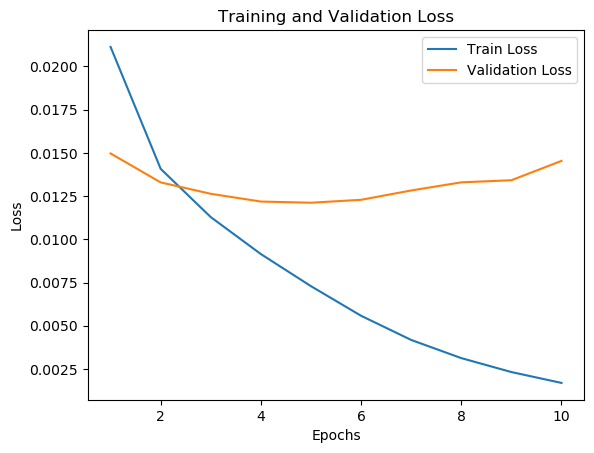

In [24]:
# Plotting Loss
plt.plot(range(1, 11), train_loss, label='Train Loss')
plt.plot(range(1, 11), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [25]:
model_save_path = './saved_models/vgg16_cifar10_RejDiff_finetuned.pth'
# Save the model
torch.save(vgg16.state_dict(), model_save_path)
print("Model saved as vgg16_cifar10_RejDiff_finetuned.pth")

Model saved as vgg16_cifar10_RejDiff_finetuned.pth


In [26]:
vgg16.load_state_dict(torch.load(model_save_path, weights_only=True))
vgg16 = vgg16.to(device)

In [27]:
# Test the final metrics on the test set
final_val_loss, final_val_accuracy, final_precision, final_recall, final_f1 = validate(vgg16, testloader)
print(f'\nFinal Test Results - Loss: {final_val_loss:.4f}, Accuracy: {final_val_accuracy:.2f}%, Precision: {final_precision:.2f}, Recall: {final_recall:.2f}, F1 Score: {final_f1:.2f}')

100%|███████████████████████████████████████████████████████████| 313/313 [00:39<00:00,  7.94it/s]



Final Test Results - Loss: 0.0145, Accuracy: 87.67%, Precision: 0.88, Recall: 0.88, F1 Score: 0.88
